In [1]:
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00


# Libraries

In [2]:
# Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

# System Libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Model
from tensorflow.keras.applications import MobileNetV2,ResNet50, ResNet50V2

# Extra
from termcolor import colored

# Data

### File Path

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/MyDrive/Dataset/Ukiyo/Train"
dir = "/content/drive/MyDrive/Dataset/Ukiyo/Train"

AI_LD_ukiyo-e  ukiyo_e


### Image per label

Number of classes in Directory folder: 2


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


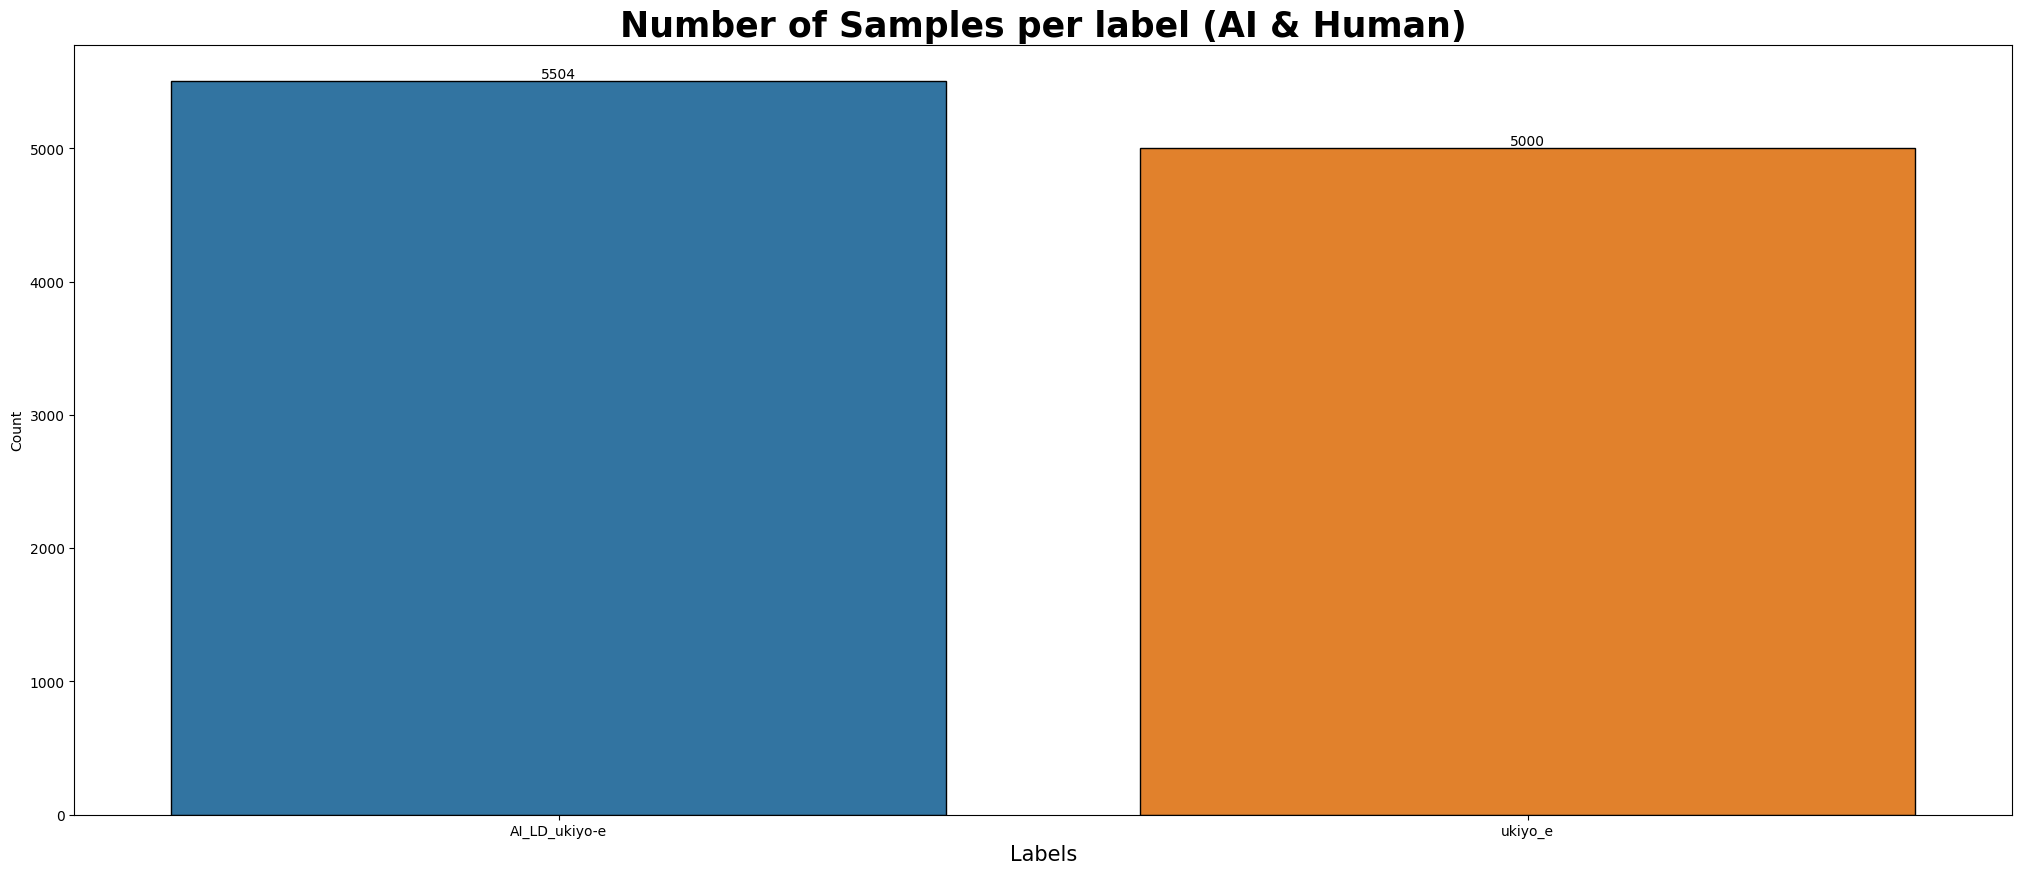

In [5]:
def num_of_classes(folder_dir, folder_name):
  classes = [class_name for class_name in os.listdir(dir)]
  print(colored(f'Number of classes in {folder_name} folder: {len(classes)}', 'green', attrs = ['bold']))
num_of_classes(dir, 'Directory')

classes = [class_name for class_name in os.listdir(dir)]
count = []

for class_name in classes:
  count.append(len(os.listdir(os.path.join(dir, class_name))))

plt.figure(figsize = (25, 10))
ax = sns.barplot(x = classes, y = count, hue = classes, edgecolor = 'black')

for i in ax.containers:
  ax.bar_label(i, )

plt.title('Number of Samples per label (AI & Human)', fontsize = 25, fontweight = 'bold')
plt.xlabel('Labels', fontsize = 15)
plt.ylabel('Count')
plt.show()

In [6]:
def create_df(folder_path, max_images_per_class=3000):
    all_images = []
    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)
        class_images = [(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)]

        # Limit the number of images per class to max_images_per_class
        all_images.extend(class_images[:max_images_per_class])

    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

dataset = create_df(dir)

In [7]:
dataset

file_path          label
0     /content/drive/MyDrive/Dataset/Ukiyo/Train/AI_...  AI_LD_ukiyo-e
1     /content/drive/MyDrive/Dataset/Ukiyo/Train/AI_...  AI_LD_ukiyo-e
2     /content/drive/MyDrive/Dataset/Ukiyo/Train/AI_...  AI_LD_ukiyo-e
3     /content/drive/MyDrive/Dataset/Ukiyo/Train/AI_...  AI_LD_ukiyo-e
4     /content/drive/MyDrive/Dataset/Ukiyo/Train/AI_...  AI_LD_ukiyo-e
...                                                 ...            ...
5995  /content/drive/MyDrive/Dataset/Ukiyo/Train/uki...        ukiyo_e
5996  /content/drive/MyDrive/Dataset/Ukiyo/Train/uki...        ukiyo_e
5997  /content/drive/MyDrive/Dataset/Ukiyo/Train/uki...        ukiyo_e
5998  /content/drive/MyDrive/Dataset/Ukiyo/Train/uki...        ukiyo_e
5999  /content/drive/MyDrive/Dataset/Ukiyo/Train/uki...        ukiyo_e

[6000 rows x 2 columns]

### Plot random image AI Generated & Human

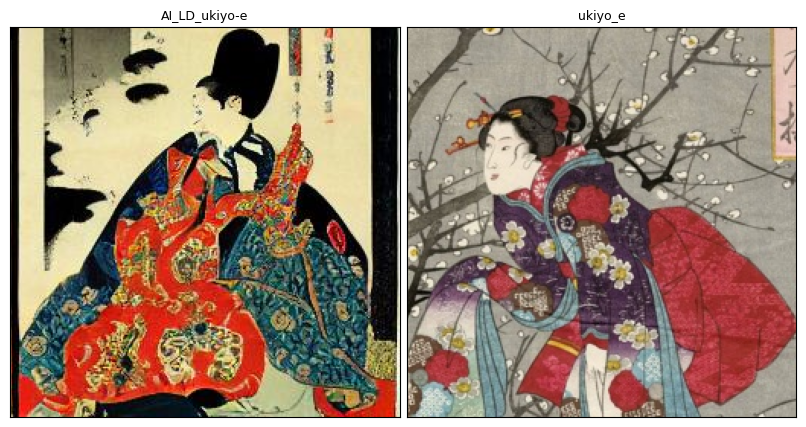

In [8]:
df_unique = dataset.copy().drop_duplicates(subset = ['label']).reset_index()

fig, axes = plt.subplots(1, 2, figsize = (8, 7),
                         subplot_kw = {'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df_unique.file_path[i]))
  ax.set_title(df_unique.label[i], fontsize = 9)
plt.tight_layout(pad = 0.5)
plt.show()

# Data Processing

### Splitting Training, Validation, and Testing

In [9]:
train, test = train_test_split(dataset, test_size = 0.2, random_state = 0)
val, test = train_test_split(test, test_size = 0.5, random_state = 0)

### Target Size & Batch

In [10]:
TARGET_SIZE = (256, 256)
BATCH_SIZE = 32

### Augmentation

#### Train

In [11]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    shear_range = 0.1,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_dataframe(
  dataframe = train,
  x_col = 'file_path',
  y_col = 'label',
  target_size = TARGET_SIZE,
  color_mode = 'rgb',
  class_mode = 'categorical',
  batch_size = BATCH_SIZE,
  shuffle = True,
  seed = 42
)

Found 4800 validated image filenames belonging to 2 classes.


#### Validation

In [12]:
#Validation Generator
val_datagen = ImageDataGenerator(rescale=1./255,)

val_generator = val_datagen.flow_from_dataframe(
  dataframe = val,
  x_col = 'file_path',
  y_col = 'label',
  target_size = TARGET_SIZE,
  color_mode = 'rgb',
  class_mode = 'categorical',
  batch_size = BATCH_SIZE,
  shuffle = False,
  seed = 42
)

Found 600 validated image filenames belonging to 2 classes.


#### Test

In [13]:
test_datagen = ImageDataGenerator(rescale=1. / 255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    x_col = 'file_path',
    y_col = 'label',
    target_size = TARGET_SIZE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    seed = 42,
    shuffle = False
)

Found 600 validated image filenames belonging to 2 classes.


# Modeling

### Create Model

In [14]:
base_model = ResNet50(weights=None, include_top=False, input_shape=(256, 256, 3))

# Build the model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())  # Global Average Pooling layer

# Add a Dense layer with L2 regularization
model.add(layers.Dense(512, activation='relu'))

# Add a Dropout layer for regularization
model.add(layers.Dropout(0.5))

# Output layer (binary classification, hence the sigmoid activation)
model.add(layers.Dense(2, activation='softmax'))

### Callbacks

In [15]:
# Model Checkpoint
checkpoint_cb = ModelCheckpoint('MyModel.weights.h5', save_best_only=True, save_weights_only=True, save_freq='epoch')

# Early Stopping
earlystop_cb = EarlyStopping(patience=3, restore_best_weights=True)

# ReduceLRonPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [16]:
model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

# Train & Evaluation

### Train

In [17]:
history = model.fit(
    train_generator,
    epochs = 50,
    validation_data = val_generator,
    callbacks = [checkpoint_cb, earlystop_cb, reduce_lr],
    batch_size = 32
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 917s 5s/step - accuracy: 0.9057 - loss: 0.4364 - val_accuracy: 0.5183 - val_loss: 3.4306 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 148s 710ms/step - accuracy: 0.9577 - loss: 0.2021 - val_accuracy: 0.5250 - val_loss: 3.2027 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 143s 718ms/step - accuracy: 0.9653 - loss: 0.1019 - val_accuracy: 0.9517 - val_loss: 0.1613 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 108s 696ms/step - accuracy: 0.9524 - loss: 0.1288 - val_accuracy: 0.8833 - val_loss: 0.4563 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 108s 689ms/step - accuracy: 0.9638 - loss: 0.1119 - val_accuracy: 0.9017 - val_loss: 0.2322 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 111s 713ms/step - accuracy: 0.9728 - loss: 0.0732 - val_accuracy: 0.8700 - val_loss: 0.2975 - learning_rate: 0.0010


### Model Evaluation

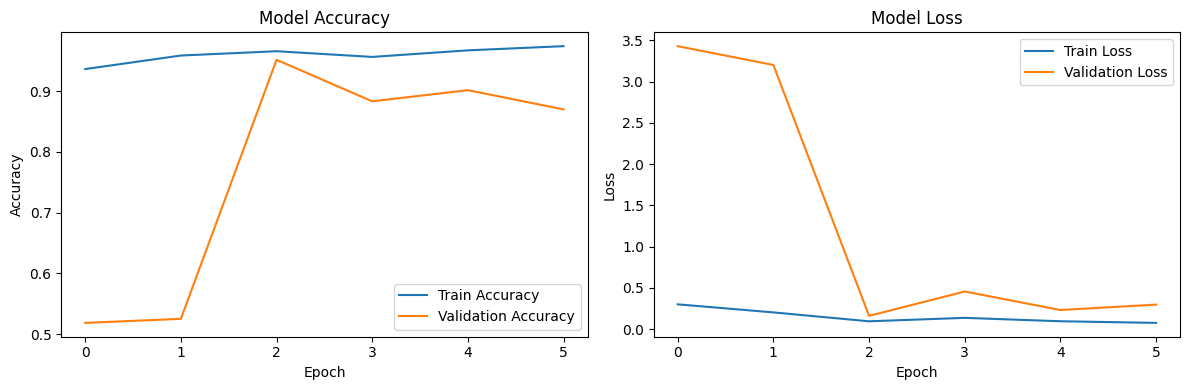

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [19]:
model.evaluate(test_generator)

19/19 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.9618 - loss: 0.1424


[0.142338365316391, 0.9649999737739563]

19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step


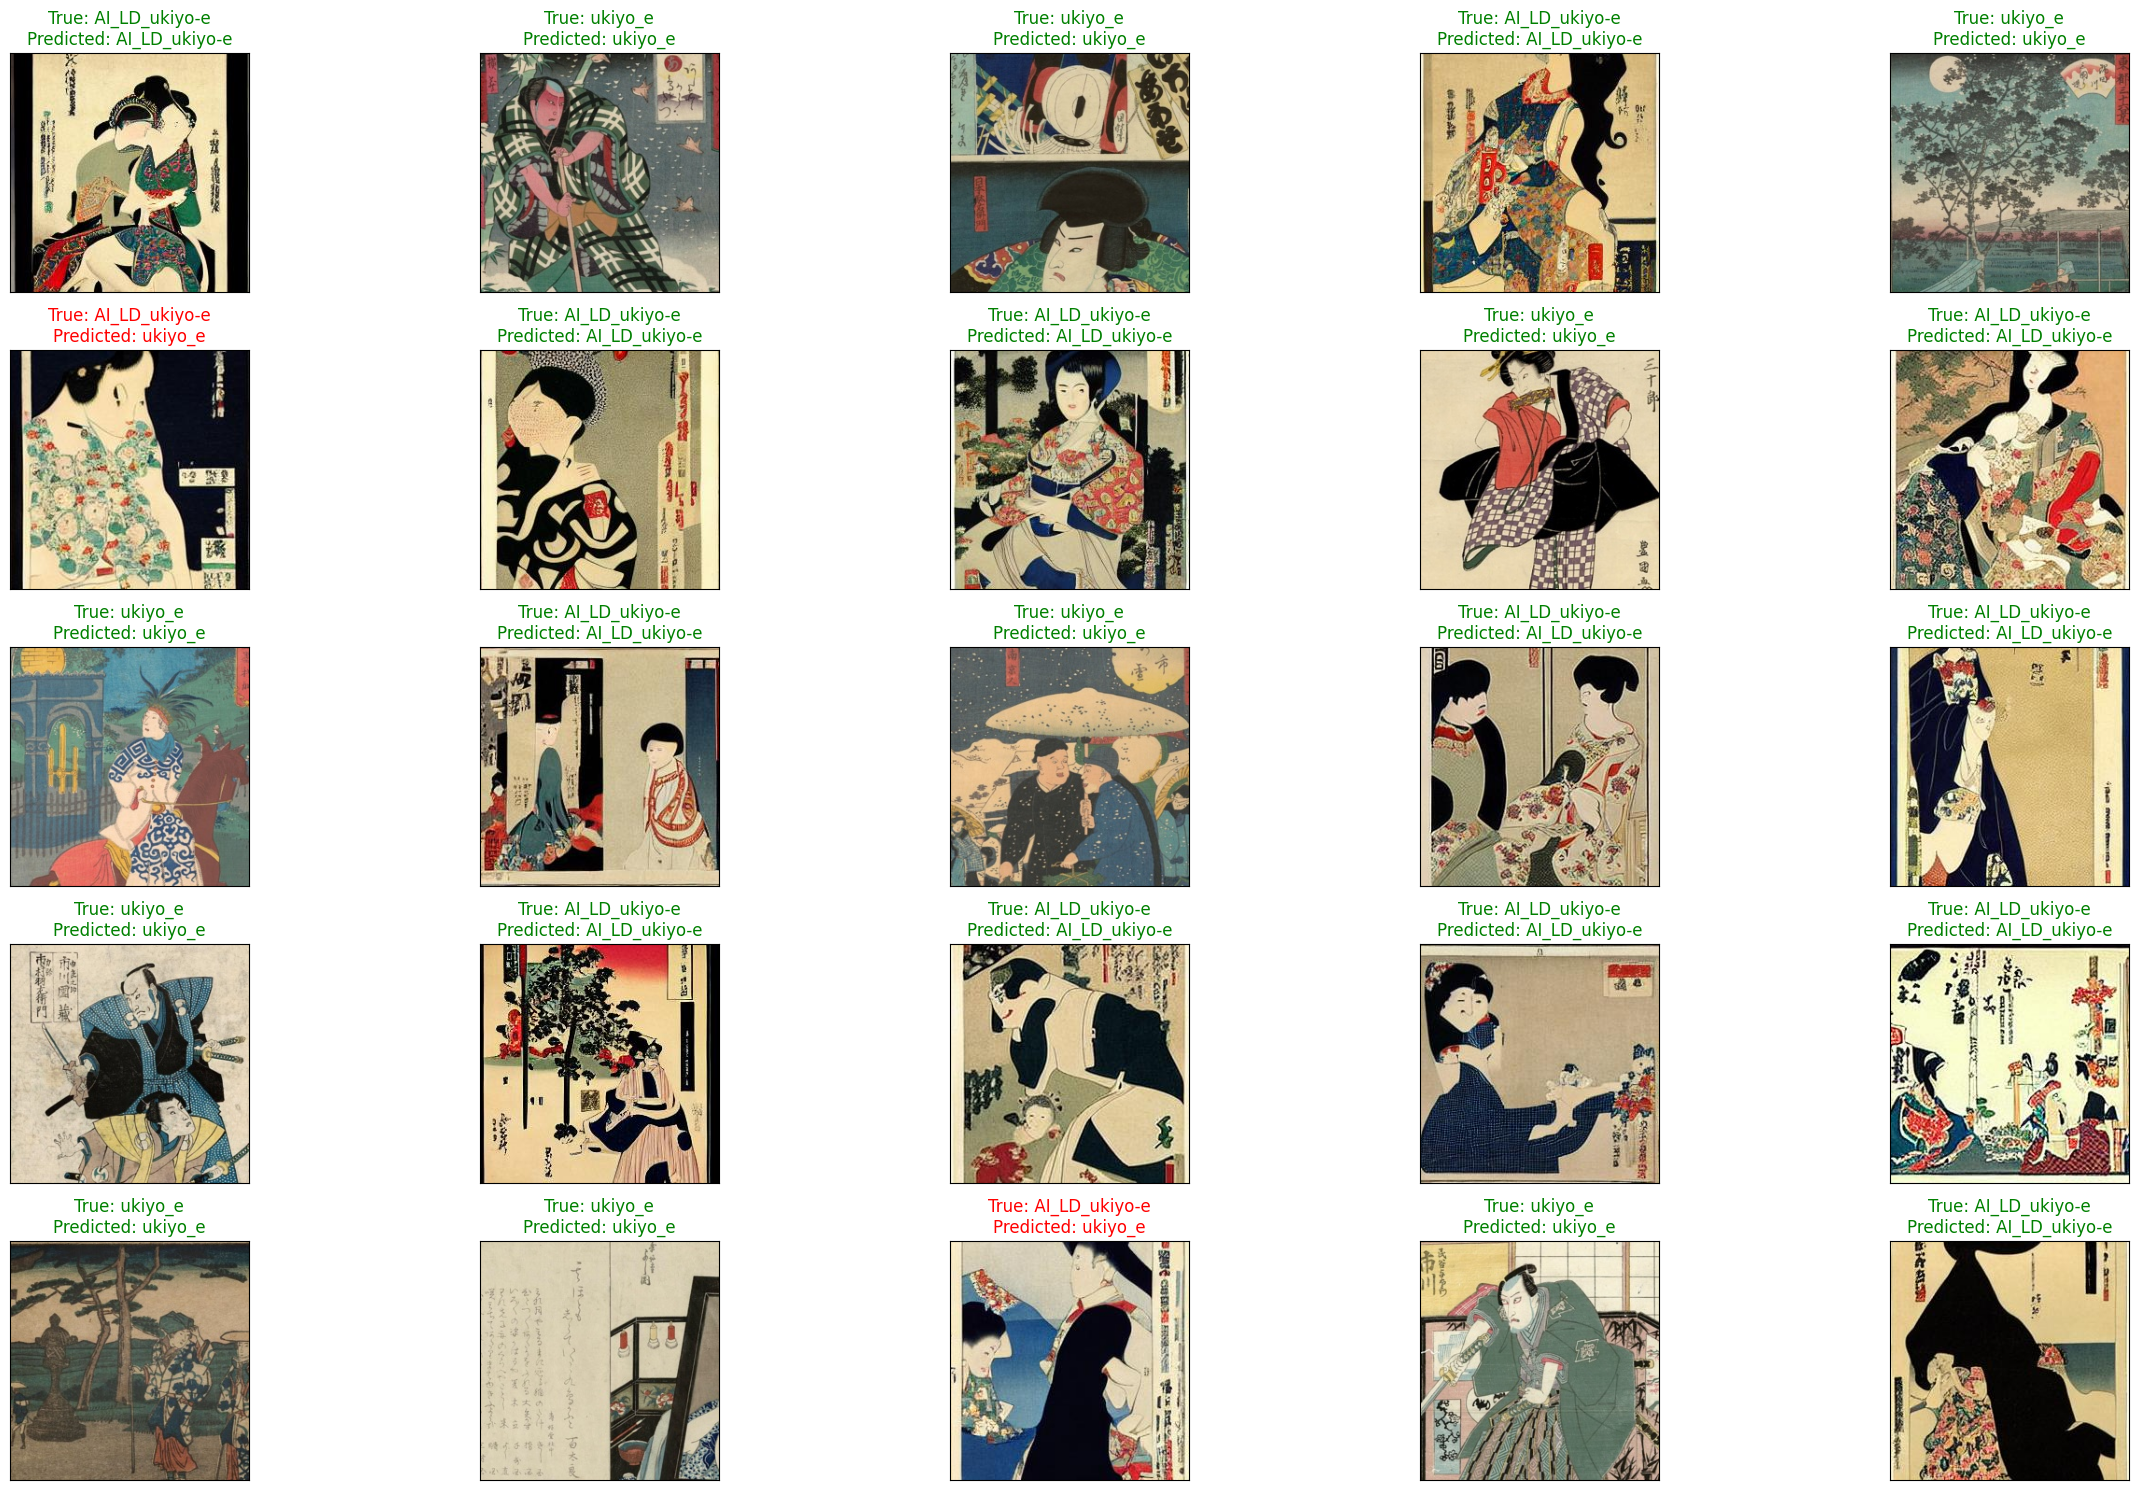

In [20]:
num_images = len(test)  # Assuming `test_dataset` is a pandas DataFrame with the test data

class_labels = list(train_generator.class_indices.keys())

# Getting all the true labels for the validation set
true_labels = test_generator.classes

# To get the predicted labels, we predict using the model
predictions = model.predict(test_generator, steps=len(test_generator))

# Take the argmax to get the predicted class indices.
predicted_labels = np.argmax(predictions, axis=1)

random_index = np.random.randint(0, len(test) - 1, num_images)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 15),
                             subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
        # Replace 'file_path' and 'class_label' with the correct column names for image paths and labels
        img_path = test['file_path'].iloc[random_index[i]]
        true_label = test['label'].iloc[random_index[i]]

        # Get the predicted class index and map it to the class name
        pred_index = predicted_labels[random_index[i]]
        pred_label = class_labels[pred_index]  # Convert the index to the class name

        # Display the image
        ax.imshow(plt.imread(img_path))

        # Determine the color of the title based on prediction accuracy
        if true_label == pred_label:
            color = "green"
        else:
            color = "red"

        # Set title showing true and predicted class names
        ax.set_title(f"True: {true_label}\nPredicted: {pred_label}", color=color)

plt.tight_layout()
plt.show()

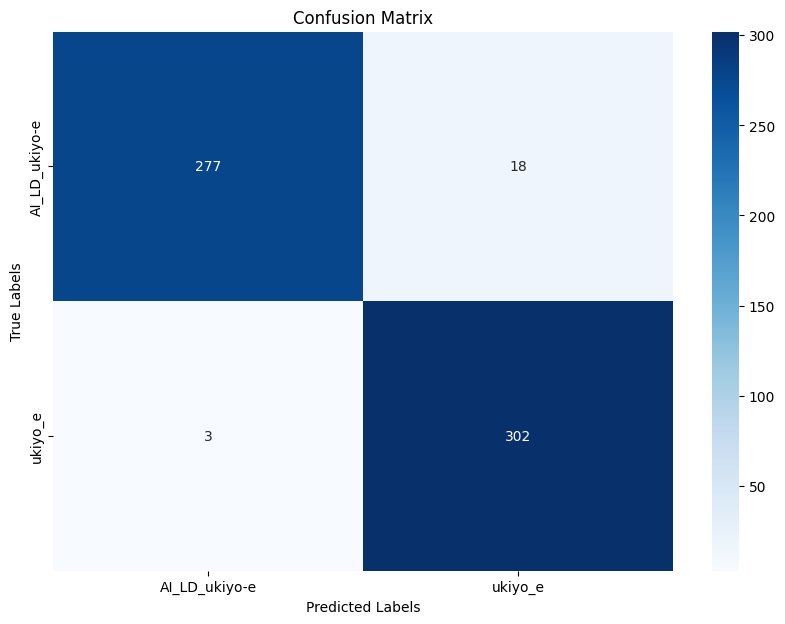

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Getting all the true labels for the test set (already given in your code)
true_labels = test_generator.classes

# Predicted labels from the model (already given in your code)
predicted_labels = np.argmax(predictions, axis=1)

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get class labels from the test generator or manually set them
class_names = list(train_generator.class_indices.keys())  # Ensure this is the correct order

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
